## Uses the emergent embeddings for the Advection-Diffusion dataset found in 
## Diffusion_Convection/1_80_100/ForNN
## and creates a PINNs model. 

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from pyDOE import lhs

import os
import sys
import time

from collections import OrderedDict

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

from DenseNN import DenseNN

torch.manual_seed(1234)
np.random.seed(1234)

plt.rc('text', usetex=False); 
plt.rc('xtick', labelsize=16); 
plt.rc('ytick', labelsize=16);
plt.rc('axes', labelsize=20, titlesize=20); 
plt.rc('figure', titlesize=20); 
plt.rc('font', family='serif');
plt.rc('font', family='serif');

In [2]:
DATA_PATH = '../Diffusion_Convection/1_80_100/ForNN/'

U_or = np.load(f"{DATA_PATH}U.npy")
x_emb = np.load(f"{DATA_PATH}x_evec.npy")
t_emb = np.load(f"{DATA_PATH}t_evec.npy")

# CUDA support 
if torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Obtain emergent embeddings (pre-saved from questionnaire algorithm) and resort data by emergent embeddings.

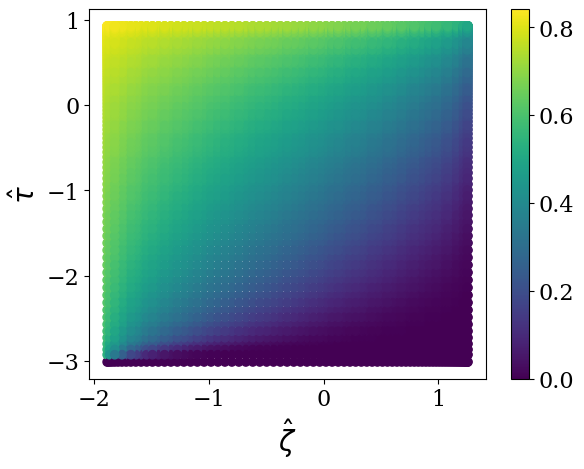

In [3]:
x = np.zeros(len(x_emb)*len(t_emb))
t = np.zeros(len(x_emb)*len(t_emb))
U = np.zeros(len(x_emb)*len(t_emb))

# resorts concentrations (U) by emergent embeddings
count = 0
for i, x_ev in enumerate(x_emb):
    for j, t_ev in enumerate(t_emb):
        U[count] = U_or[i, j]
        x[count] = x_ev
        t[count] = t_ev
        count +=1

X = np.array(np.vstack((x, t)).T)

# plot to ensure reorganization
plt.scatter(x, t, c=U)
plt.xlabel(r"$\hat{\zeta}$")
plt.ylabel(r"$\hat{\tau}$")
plt.colorbar()
plt.show()


In [4]:
N = 100

phi_wholespace = np.linspace(min(x), max(x), N)
psi_wholespace = np.linspace(min(t), max(t), N)
phi_W, psi_W = np.meshgrid(phi_wholespace, psi_wholespace)
allpoints = np.hstack((phi_W.flatten()[:,None], psi_W.flatten()[:,None]))

Build emergent model (PINNs).

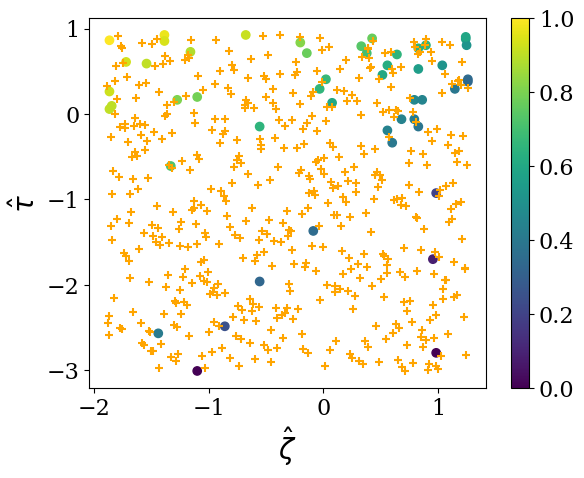

In [5]:
class PlainNN():
    """
    Physics Informed Neural Net for Advection-Diffusion equation.
    Maintain same colocation points, and calculates derivatives to be used in physics informed loss.
    """

    # X, U, lb, ub are all tensors
    def __init__(self, layers, X, U, lb, ub):

        self.ub = ub
        self.lb = lb
    
        self.dnn = DenseNN(layers)

        # data points
        self.x = X[:, 0:1]
        self.t = X[:, 1:2]
        self.U = U

        # colocation points
        np.random.seed(1234)
        colocation_points = lhs(n=2, samples=500)*(ub.clone().detach().cpu().numpy()-lb.clone().detach().cpu().numpy())+lb.clone().detach().cpu().numpy()
        self.x_c = torch.from_numpy(colocation_points[:,0:1]).float()
        self.t_c = torch.from_numpy(colocation_points[:,1:2]).float()

        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=0.001)

        self.iter = 0

        self.losslist = []
        self.phy_loss = []
        self.data_loss = []

    def set_learning_rate(self, lr):
        self.optimizer.param_groups[0]['lr'] = lr

    # X is a tensor
    def scale_input(self, X):
        return 2*(X-self.lb)/(self.ub-self.lb) - 1
    
    # z is a numpy array
    def scale_input_numpy(self, z, index): # z is a numpy array
        lb = self.lb[index].detach().cpu().numpy()
        ub = self.ub[index].detach().cpu().numpy()
        return 2*(z - lb) / (ub - lb) - 1
    
    def plot_scaled_input(self):
        plt.scatter(self.scale_input_numpy(self.x.clone().detach().cpu().numpy(), 0),
                    self.scale_input_numpy(self.t.clone().detach().cpu().numpy(), 1), 
                    c=self.U.clone().detach().cpu().numpy())
        plt.xlabel(r"$\hat{\zeta}$")
        plt.ylabel(r"$\hat{\tau}$")
        plt.colorbar()
        plt.show()

    def plot_input(self):
        plt.scatter(self.x.clone().detach().cpu().numpy(),
                    self.t.clone().detach().cpu().numpy(),
                    c=self.U.clone().detach().cpu().numpy())
        plt.scatter(self.x_c.clone().detach().cpu().numpy(),
                    self.t_c.clone().detach().cpu().numpy(),
                    color = "orange", marker="+")
        plt.xlabel(r"$\hat{\zeta}$")
        plt.ylabel(r"$\hat{\tau}$")
        plt.colorbar()
        plt.show()
    
    def net_C(self, x, t):
        return self.dnn(torch.cat([x,t], dim=1))*(t-self.lb[1]) # forces initial condition to be 0 
    
    def get_derivatives(self, x, t):

        x.requires_grad_(True)
        t.requires_grad_(True)
    
        c = self.net_C(x, t)
        
        c_t = torch.autograd.grad(
            c, t, 
            grad_outputs=torch.ones_like(c),
            #retain_graph=True,
            create_graph=True
        )[0]

        c_x = torch.autograd.grad(
            c, x, 
            grad_outputs=torch.ones_like(c),
            retain_graph=True,
            create_graph=True
        )[0]

        c_xx = torch.autograd.grad(
            c_x, x, 
            grad_outputs=torch.ones_like(c_x),
            #retain_graph=True,
            create_graph=True
        )[0]
        
        return c, c_t, c_x, c_xx
    
    def net_f(self, x, t):
        L = 1
        T = 2
        D = 0.05
        v = 0.1

        c, c_t, c_x, c_xx = self.get_derivatives(x, t)
        lhs = c_t*L/T
        rhs = D/L * c_xx - v*c_x
        return lhs, rhs

    # x, t, are numpy arrays here
    def predict(self, x, t):
        return self.dnn.predict(x, t)*(t-self.lb[1].detach().cpu().numpy()) # # forces initial condition to be 0
    
    def __call__(self, X):
        return self.predict(X[:,0:1], X[:,1:2])
    
    def parameters(self):
        return self.dnn.parameters()
    
    def train(self, num_epochs=8000, batch_size = None):
        L = 1
        T = 2
        D = 0.05
        v = 0.1

        t0 = time.time()

        if batch_size == None: batch_size = len(self.x)

        # Train the model
        losslist = []
        phy_loss = []
        data_loss = []
        for epoch in range(num_epochs):
            for i in range(0, len(self.x), batch_size):

                x_batch = self.x[i:i+batch_size].reshape(-1,1)
                t_batch = self.t[i:i+batch_size].reshape(-1,1)
                U_batch = self.U[i:i+batch_size].reshape(-1,1)
            
                self.optimizer.zero_grad()

                # colocation points
                _, c_t, c_x, c_xx = self.get_derivatives(self.x_c, self.t_c)
                lhs = c_t*L/T
                rhs = D/L * c_xx - v*c_x
                physics_loss = torch.mean(torch.square(lhs-rhs))

                # data driven
                c_pred = self.net_C(x_batch, t_batch)
                data_driven_loss = torch.mean(torch.square(c_pred-U_batch))

                loss = 1000*data_driven_loss + physics_loss
                loss.backward()
                self.optimizer.step()

            self.iter += 1
            losslist.append(loss.item())
            phy_loss.append(physics_loss.item())
            data_loss.append(data_driven_loss.item())

            if (epoch + 1) % 5000 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Time: {time.time()-t0}')
        

        # Loss Plots
        self.losslist.extend(losslist)
        self.phy_loss.extend(phy_loss)
        self.data_loss.extend(data_loss)
    
        grid = True

        plt.figure()
        plt.semilogy(np.arange(1, len(losslist)+1), losslist)
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.title('Training loss')
        plt.grid(grid)

        plt.figure()
        plt.semilogy(np.arange(1, len(losslist)+1), phy_loss, label='Physics Loss')
        plt.semilogy(np.arange(1, len(losslist)+1), data_loss, label='Data Driven Loss')
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss; Physics and Data-Driven')
        plt.legend()
        plt.grid(grid)


        lhs, rhs = self.net_f(self.x, self.t)
        print("Physics Loss")
        print(torch.mean(torch.square(lhs-rhs)))
        print("Data Driven Loss")
        print(torch.mean(torch.square(self.net_C(self.x, self.t)-self.U)))

# Convert data to PyTorch tensors
x_tensor = torch.from_numpy(x.reshape(-1,1)).float()
t_tensor = torch.from_numpy(t.reshape(-1,1)).float()
u_tensor = torch.from_numpy(U.reshape(-1,1)).float()
inputs = torch.cat((x_tensor, t_tensor), dim=1)
ub = torch.tensor([max(inputs[:,i]) for i in range(inputs.shape[1])])
lb = torch.tensor([min(inputs[:,i]) for i in range(inputs.shape[1])])

data_points = 50
indices = list(range(len(x_tensor)))
idx = np.random.choice(indices, data_points, replace=False)

# Initialize the neural network
layers = [2, 40, 40, 40, 40, 1]
model = PlainNN(layers, inputs[idx,...], u_tensor[idx,...], lb=lb, ub=ub)
model.plot_input()



Epoch [5000/40000], Loss: 0.15584537386894226, Time: 17.34557294845581
Epoch [10000/40000], Loss: 0.03204820305109024, Time: 36.12354779243469
Epoch [15000/40000], Loss: 0.09311963617801666, Time: 54.14891290664673
Epoch [20000/40000], Loss: 0.023311804980039597, Time: 71.22354674339294
Epoch [25000/40000], Loss: 0.021436583250761032, Time: 87.58063983917236
Epoch [30000/40000], Loss: 0.02008185163140297, Time: 108.4835410118103
Epoch [35000/40000], Loss: 0.016030069440603256, Time: 130.6477828025818
Epoch [40000/40000], Loss: 0.012291898019611835, Time: 151.95549893379211
Physics Loss
tensor(0.0193, grad_fn=<MeanBackward0>)
Data Driven Loss
tensor(2.2243e-06, grad_fn=<MeanBackward0>)
Epoch [5000/400000], Loss: 0.010501531884074211, Time: 21.530017614364624
Epoch [10000/400000], Loss: 0.00997460912913084, Time: 43.44921660423279
Epoch [15000/400000], Loss: 0.009763640351593494, Time: 65.67158770561218
Epoch [20000/400000], Loss: 0.009619830176234245, Time: 87.11788868904114
Epoch [2500

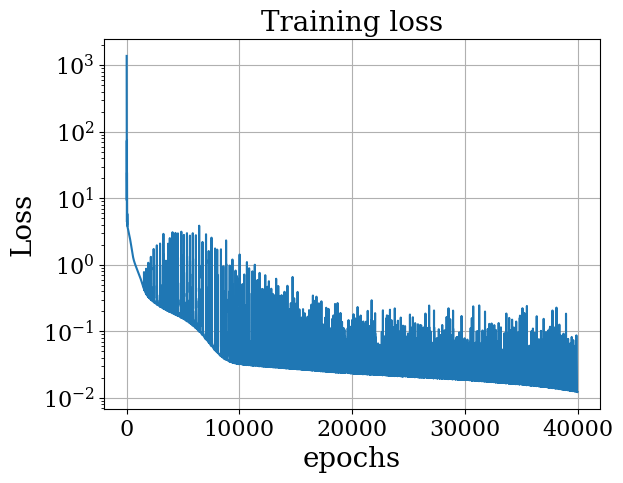

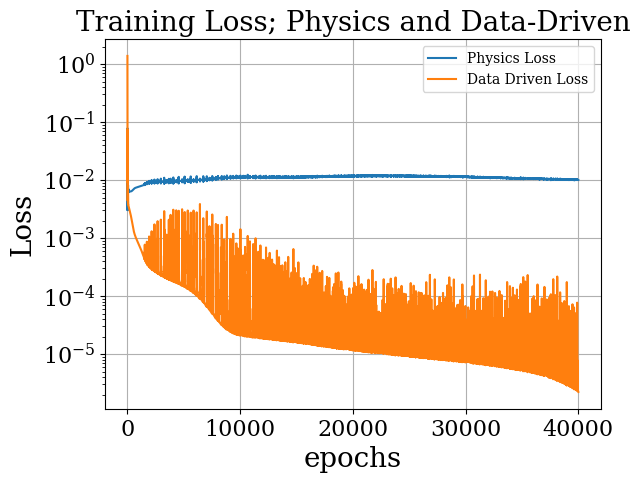

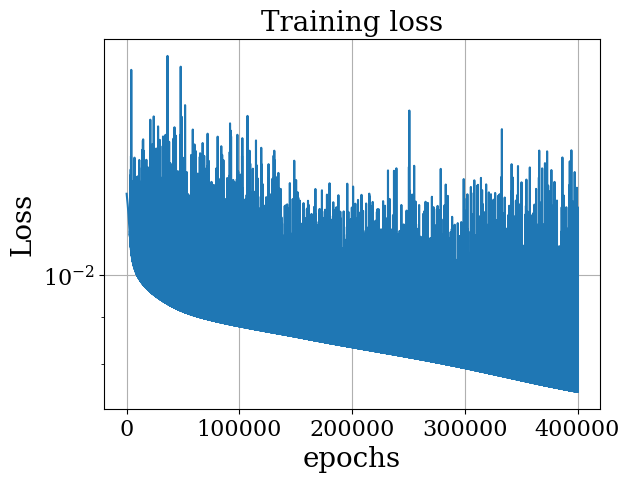

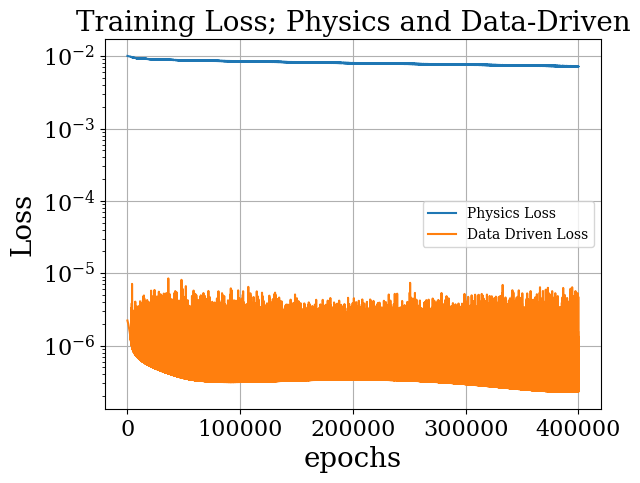

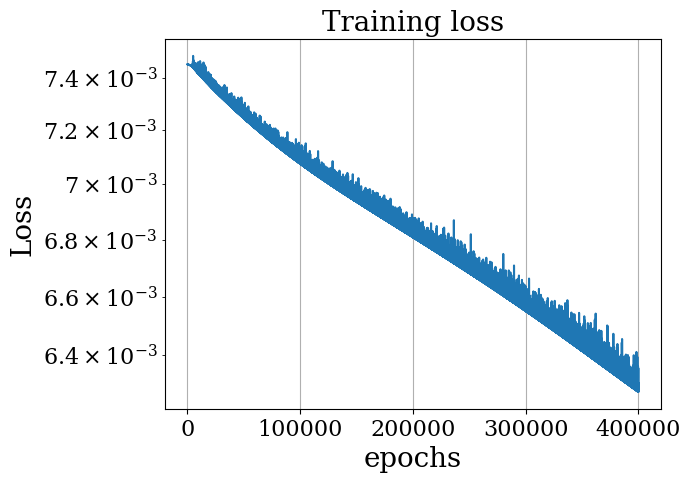

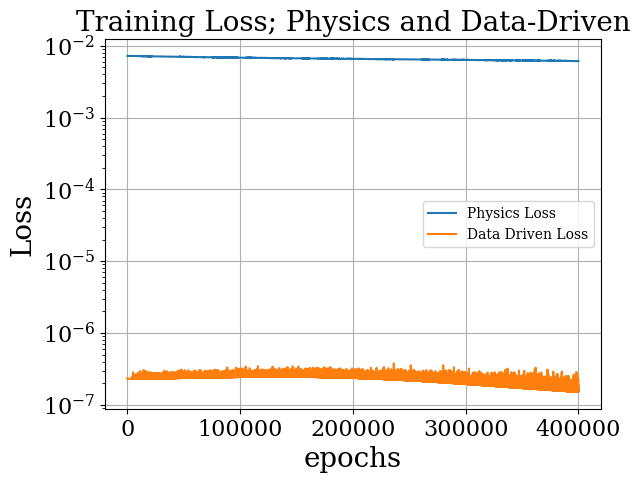

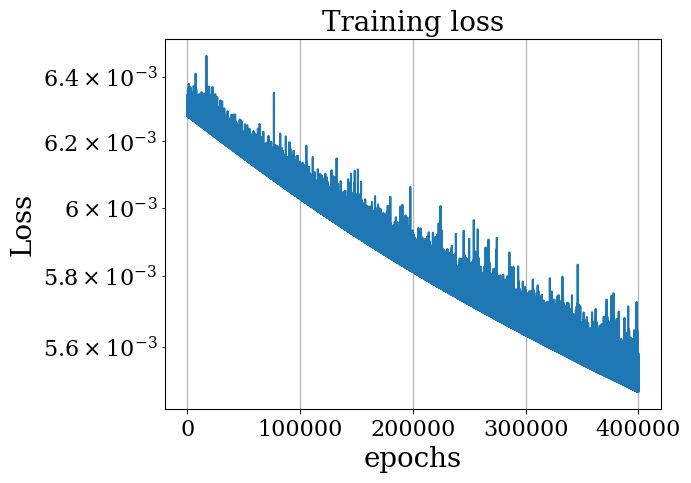

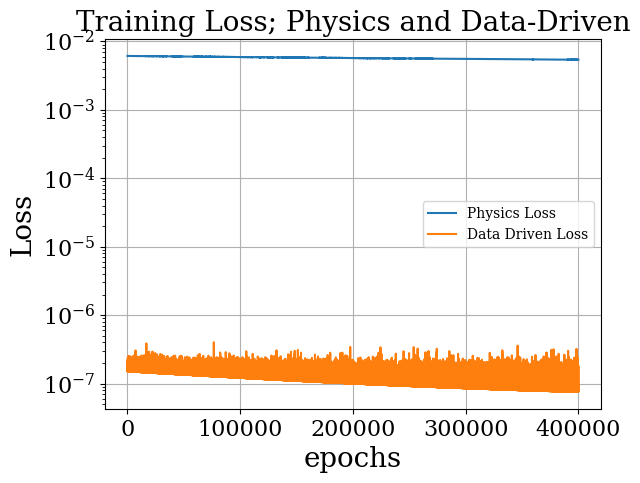

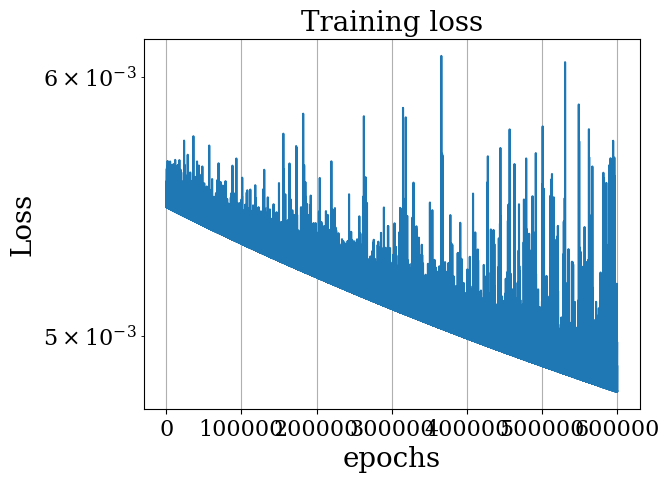

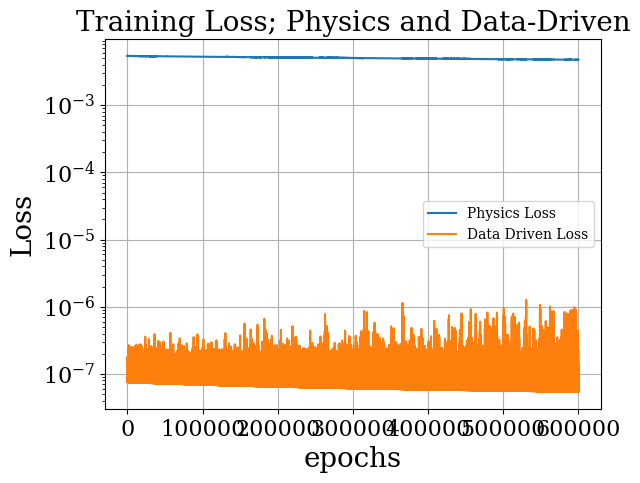

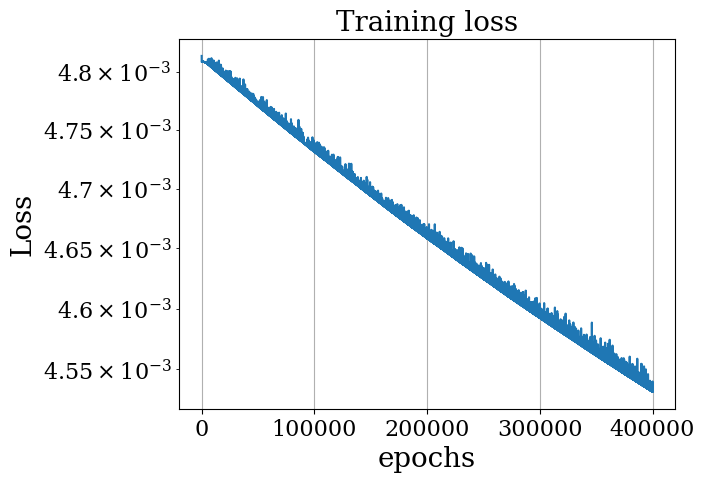

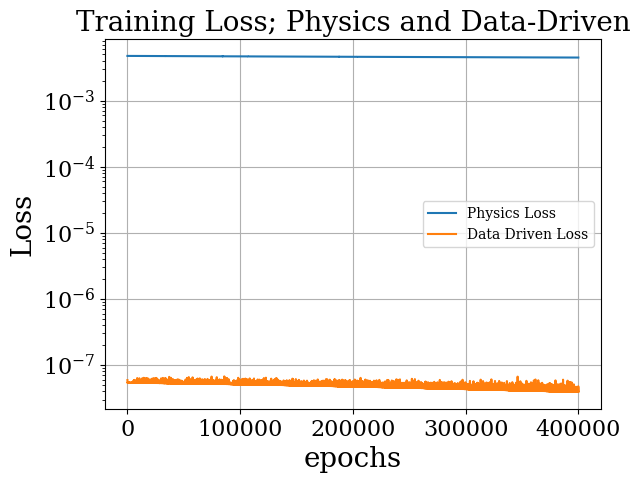

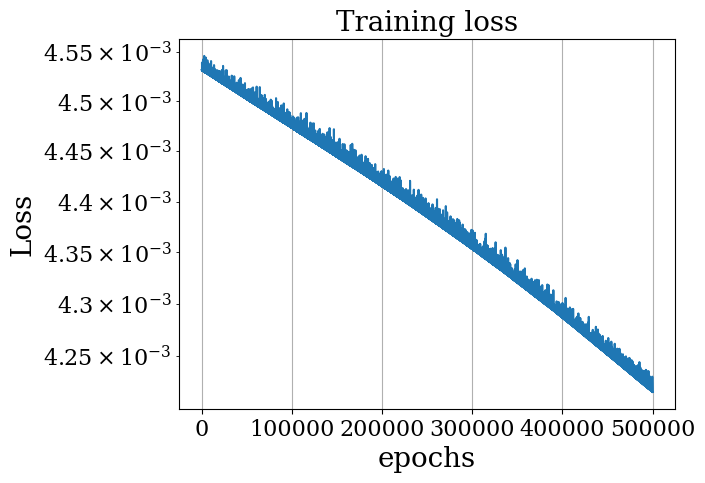

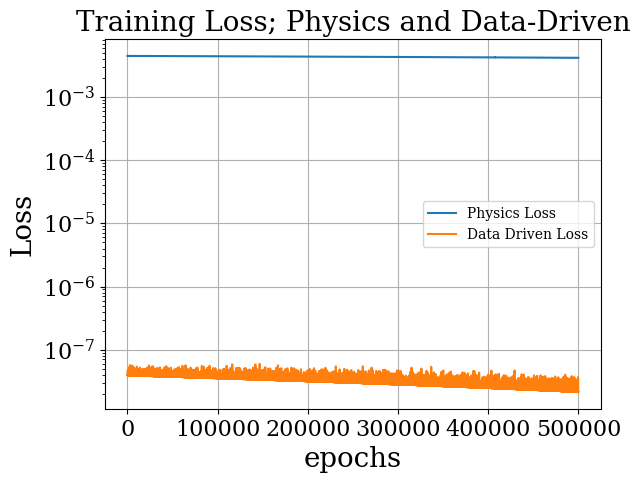

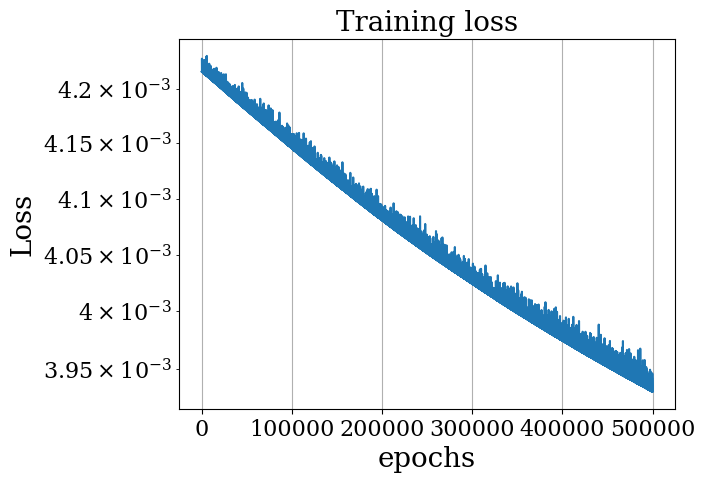

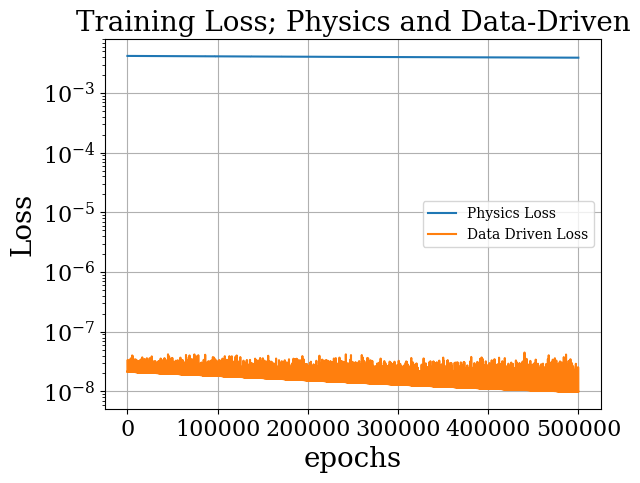

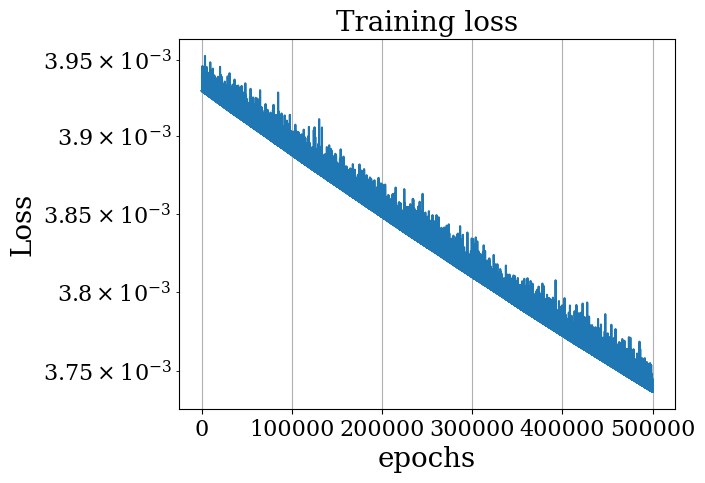

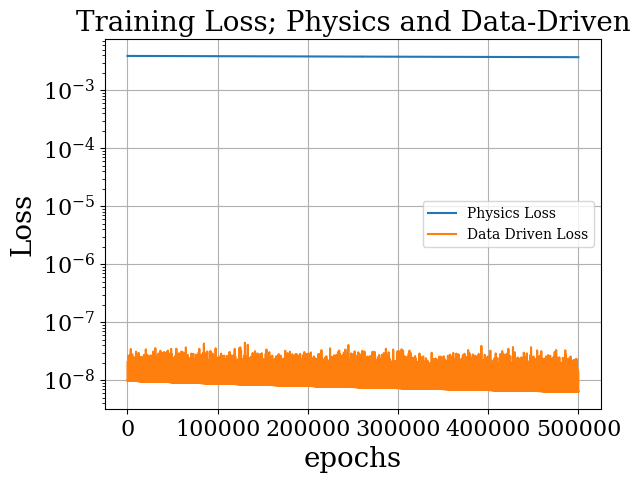

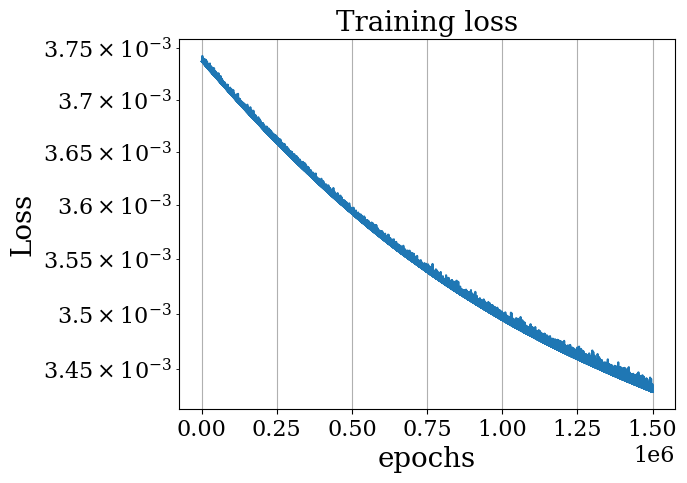

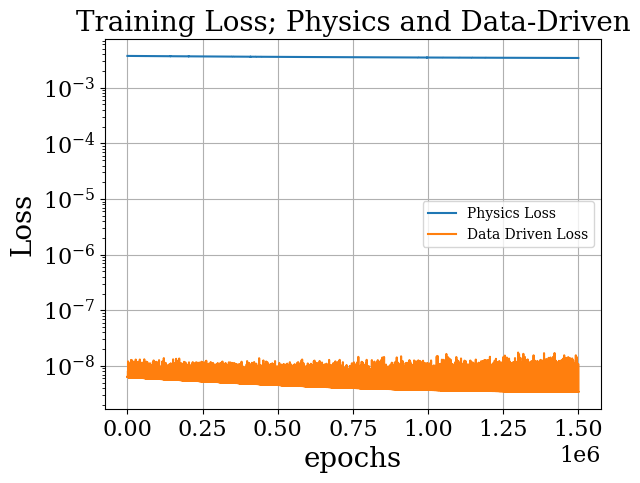

In [6]:
model.train(num_epochs=40000)

model.set_learning_rate(0.0001)
model.train(num_epochs=400000)

model.set_learning_rate(0.00001)
model.train(num_epochs=400000)

# continue training, if desired
model.train(num_epochs=400000)
model.train(num_epochs=600000)

model.set_learning_rate(0.000001)
model.train(num_epochs=400000)

model.set_learning_rate(0.000001)
model.train(num_epochs=500000)


model.set_learning_rate(0.000001)
model.train(num_epochs=500000)

model.set_learning_rate(0.000001)
model.train(num_epochs=500000)

model.set_learning_rate(0.0000005)
model.train(num_epochs=1500000)


Epoch [5000/50000], Loss: 0.0034290787298232317, Time: 14.49638295173645
Epoch [10000/50000], Loss: 0.003428532276302576, Time: 28.865808248519897
Epoch [15000/50000], Loss: 0.003427964635193348, Time: 43.08462309837341
Epoch [20000/50000], Loss: 0.0034274279605597258, Time: 57.42009115219116
Epoch [25000/50000], Loss: 0.003426883602514863, Time: 71.76484107971191
Epoch [30000/50000], Loss: 0.0034263592679053545, Time: 86.12508010864258
Epoch [35000/50000], Loss: 0.003425810020416975, Time: 100.51112604141235
Epoch [40000/50000], Loss: 0.0034252835903316736, Time: 114.86321115493774
Epoch [45000/50000], Loss: 0.0034247280564159155, Time: 129.23388600349426
Epoch [50000/50000], Loss: 0.0034241878893226385, Time: 143.6580171585083
Physics Loss
tensor(0.0344, grad_fn=<MeanBackward0>)
Data Driven Loss
tensor(3.4207e-09, grad_fn=<MeanBackward0>)
TEST MSE:  0.10917599587208338


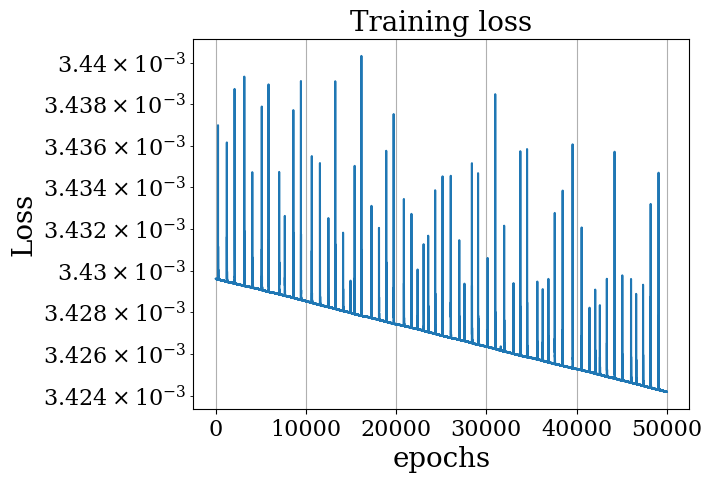

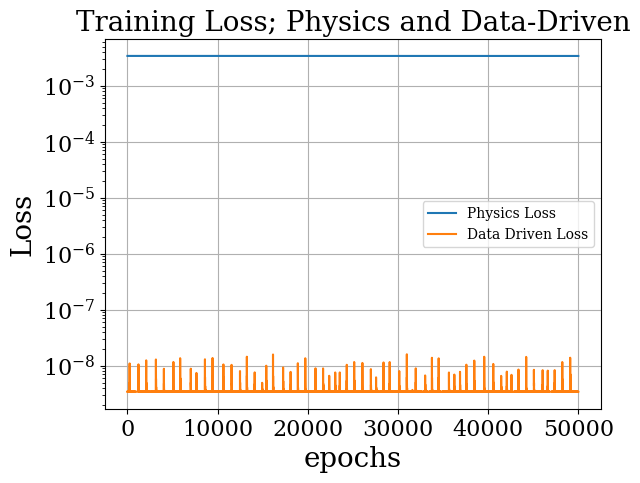

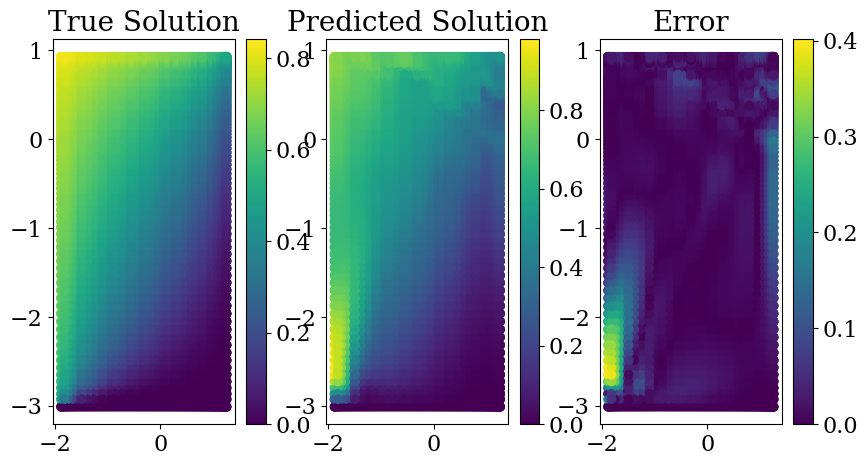

In [7]:
model.set_learning_rate(0.0000005)
model.train(num_epochs=50000)

u_pred = model.predict(x.reshape(-1,1), t.reshape(-1,1)).reshape(-1, 1)
print("TEST MSE: ", np.mean(np.square(u_pred-U)))

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('True Solution')
plt.scatter(x, t, c = U)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('Predicted Solution')
plt.scatter(x, t, c=u_pred)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Error')
plt.scatter(x, t, c=np.abs(U-u_pred[:,0]))
plt.colorbar()
plt.show()

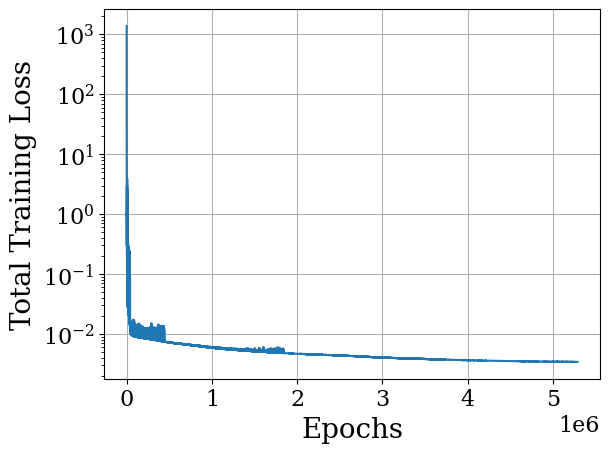

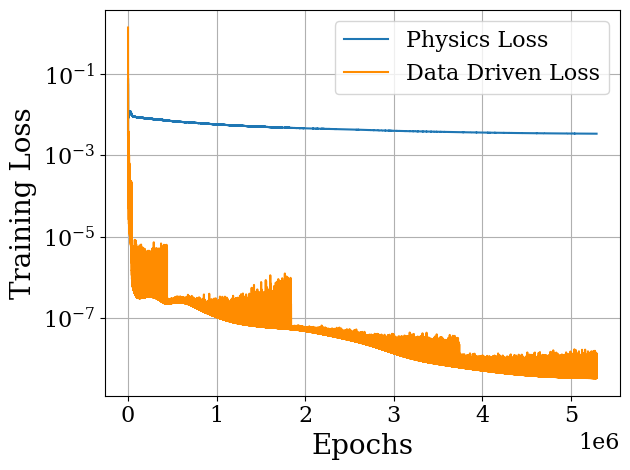

In [8]:

grid = True


plt.figure()
plt.semilogy(np.arange(1, len(model.losslist)+1), model.losslist)
plt.xlabel('Epochs')
plt.ylabel('Total Training Loss')
#plt.title('Total Training loss')
plt.grid(grid)
plt.savefig(f"./Figures/pipe_total_training.pdf", dpi=300, format='pdf')

np.savetxt(f"./Figures/phy_loss", model.phy_loss)
np.savetxt(f"./Figures/data_loss", model.data_loss)

plt.figure()
plt.semilogy(np.arange(1, len(model.losslist)+1), model.phy_loss, label='Physics Loss')
plt.semilogy(np.arange(1, len(model.losslist)+1), model.data_loss, label='Data Driven Loss', color="darkorange")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend(fontsize=16)
plt.grid(grid)
plt.tight_layout()
plt.savefig(f"./Figures/pipe_separate_training.pdf", dpi=300, format='pdf')


In [9]:

# Plot the solution field
u_pred = model.predict(x.reshape(-1,1), t.reshape(-1,1)).reshape(-1, 1)
print("TEST MSE: ", np.mean(np.square(u_pred-U)))

TEST MSE:  0.10917599587208338


/var/folders/0h/w_d_nbpn21v3wpdv3l048nm80000gn/T/ipykernel_48498/3788834970.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


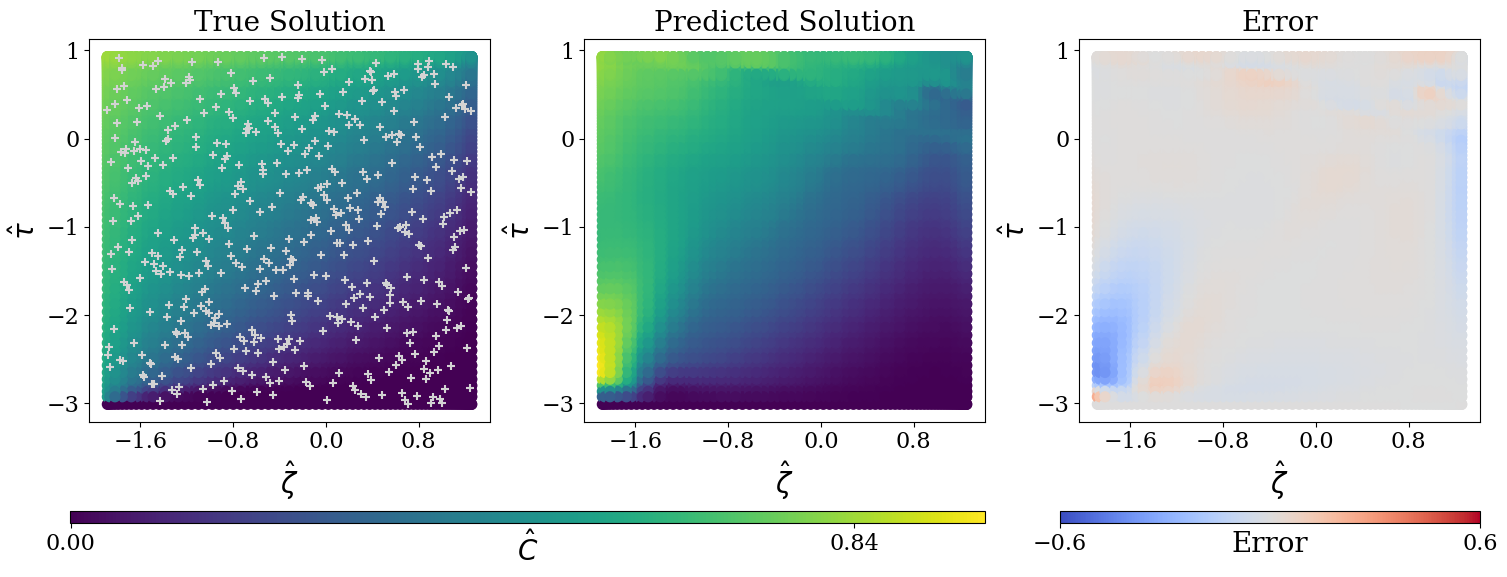

In [10]:
from matplotlib.ticker import MaxNLocator

# Determine common color limits
vmin = min(U.min(), u_pred[:,0].min())
vmax = max(U.max(), u_pred[:,0].max())


# Plot settings
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# True Solution
sc1 = axs[0].scatter(x, t, c=U, cmap='viridis', vmin=vmin, vmax=vmax, s=50)
axs[0].set_title('True Solution')
axs[0].set_xlabel(r"$\hat{\zeta}$")
axs[0].set_ylabel(r"$\hat{\tau}$")


# Colocation Points
sc11 = axs[0].scatter(model.x_c.clone().detach().cpu().numpy(),
                      model.t_c.clone().detach().cpu().numpy(),
                      color="lightgray", marker="+", zorder=100, s=35)

# Set fewer x and y ticks
axs[0].xaxis.set_major_locator(MaxNLocator(5))  # Set max 5 x-ticks
axs[0].yaxis.set_major_locator(MaxNLocator(5))  # Set max 5 y-ticks


# Predicted Solution
sc2 = axs[1].scatter(x, t, c=u_pred, cmap='viridis', vmin=vmin, vmax=vmax, s=50)
axs[1].set_title('Predicted Solution')
axs[1].set_xlabel(r"$\hat{\zeta}$")
axs[1].set_ylabel(r"$\hat{\tau}$")

# Set fewer x and y ticks
axs[1].xaxis.set_major_locator(MaxNLocator(5))  # Set max 5 x-ticks
axs[1].yaxis.set_major_locator(MaxNLocator(5))  # Set max 5 y-ticks

# Error Plot
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
nodes = [0.0, 0.5, 1.0] # Define the positions of the colors
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))


error = U - u_pred[:,0]
sc3 = axs[2].scatter(x, t, c=error, cmap="coolwarm", vmin=-0.6, vmax=0.6, s=50)
# Set fewer x and y ticks
axs[2].xaxis.set_major_locator(MaxNLocator(5))  # Set max 5 x-ticks
axs[2].yaxis.set_major_locator(MaxNLocator(5))  # Set max 5 y-ticks
axs[2].set_title('Error')
axs[2].set_xlabel(r"$\hat{\zeta}$")
axs[2].set_ylabel(r"$\hat{\tau}$")

from mpl_toolkits.axes_grid1 import make_axes_locatable


# Create shared colorbar for the first two plots
cbar_ax = fig.add_axes([0.05, 0.07, 0.61, 0.02]) 
cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_label_position('bottom')
cbar.set_label(r"$\hat{C}$", labelpad=-17)
cbar.set_ticks([0, 0.84])

# Create colorbar for the third plot
cbar_ax3 = fig.add_axes([0.71, 0.07, 0.28, 0.02])  
cbar3 = fig.colorbar(sc3, cax=cbar_ax3, orientation='horizontal')
cbar3.set_label('Error', labelpad=-17)
cbar3.set_ticks([-0.6, 0.6])

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
fig.savefig(f"./Figures/pipe_error.pdf", dpi=300, format='pdf')

plt.show()

In [11]:
# save out data

datapath = f"./Data/"

np.save(datapath+"U.npy", U)
np.save(datapath+"u_pred.npy", u_pred)
np.save(datapath+"x.npy", x)
np.save(datapath+"t.npy", t)
np.save(datapath+"x_c.npy", x)
np.save(datapath+"t_c.npy", t)